This jupyter notebook is the source code for "Model-free Control of Chaos with Continuous Deep Q-learning" ver. 4.

https://arxiv.org/pdf/1907.07775.pdf

In [165]:
import numpy as np
from numpy.random import *

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


# 1. Gumowski Mira Map

We consider the following Gumowski Mira map.

$$
x_{k+1}=y_{k} + b(1-0.05y_k^2)y_k +f(x_k),\\
y_{k+1}=-x_{k}+f(x_{k+1}),
$$

where 

$$
f(x)=\eta x + \frac{2(1-\eta)x^{2}}{1+x^{2}}.
$$

In this simulation, $b=0.008$ and $\eta=-0.8$. The system is one of discrete-time chaos systems. Moreover, we input a control input $u_k$ to the chaos system.  

In [166]:
def F_mira(x):
    
    eta = -0.8
    
    return_val = eta*x + (2*(1-eta)*x**(2))/(1+x**(2))
    
    return return_val

def mira(x,y,u):
    
    b = 0.008
    
    next_x = y + b*(1-0.05*y**(2))*y+F_mira(x)+ 0.1*u
    next_y = -x + F_mira(next_x)
    
    next_state = np.zeros((1,2))
    next_state[0,0] = next_x
    next_state[0,1] = next_y
    
    return next_state

It is assumed that we cannot calculate a precise value of the stabilizing periodic orbits embedded in its chaotic attractor using the mathematical model. On the other hand, although the state of the chaotic system does not converge to the periodic orbit, it is sometimes close to any unstable periodic orbit embedded in the chaotic attractor. Using this property, we observe the behavior of the chaotic system without the control input and sample states that are close to the stabilizing periodic orbit.

In [167]:
x_list = []
y_list = []
x_f_list = []
y_f_list = []

# initial state
x = 1.2
y = 0.3

for step in range(5000000):

    if step > 20:
        x_list.append(x)
        y_list.append(y)
    
        next_state = mira(x,y,0.0)
        
        if abs(next_state[0,0] - x) + abs(next_state[0,1] - y) < 0.02:
            x_f_list.append(x)
            y_f_list.append(y)
            
        x = next_state[0,0]
        y = next_state[0,1]

The follwoing figure shows the plot of the chaos system.

Text(0, 0.5, '$y_k$')

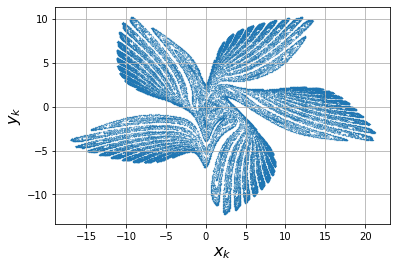

In [168]:
plt.grid(True)
plt.scatter(x_list[0:100000], y_list[0:100000], s=0.01)
plt.xlabel('$x_k$',fontsize=16)
plt.ylabel('$y_k$',fontsize=16)

The following figure shows the region near the point $(1.0, 0.0)$. The orange points satisfy 

$$
|x_{k+1}-x_{k}| + |y_{k+1}-y_{k}| < 0.02.
$$

Text(0, 0.5, '$y_k$')

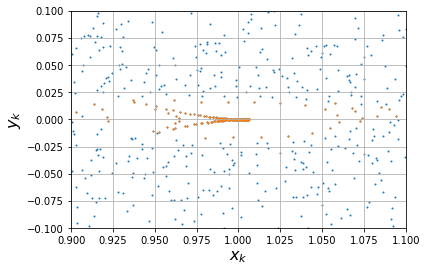

In [169]:
plt.grid(True)
plt.xlim(0.9,1.1)
plt.ylim(-0.1,0.1)
plt.scatter(x_list, y_list, s= 1)
plt.scatter(x_f_list, y_f_list, s= 1)
plt.xlabel('$x_k$',fontsize=16)
plt.ylabel('$y_k$',fontsize=16)

The estimated fixed point is

In [170]:
estimated_fixed_x = sum(x_f_list)/len(x_f_list)
estimated_fixed_y = sum(y_f_list)/len(y_f_list)
print('('+str(estimated_fixed_x)+','+str(estimated_fixed_y)+')')

(0.9937459856632298,0.0010636191464837765)


Then, we set the following region $D$ appropriately based on the estimated fixed point $(\hat{x}_{f},\hat{y}_{f})=(0.994, 0.001)$.

$$
D=\{(x,y)|\ x_f-1\le x\le x_f+1,\ y_f-1\le y\le y_f+1\}.
$$

In this notebook, since we use a deep neural network to design a chaos controller, we can make a learner learn a nonlinear control policy for a large region while both the OGY method and the delayed feedback control method are linear control methods.

# 2. Application of DRL to Chaos Control

## Reward Function

We apply deep reinforcement learning to chaos control. Then, we define the following reward function.

$$
R(s, u, s')=\begin{cases}
    -(s-s')^{\top}M_1(s-s')-u^{\top}M_2 u & \text{if} s'\neq s_{out}\\
    -q & \text{otherwise},
\end{cases}
$$

$s=[s_x,s_y]^{\top}$ (or $s'$) is a transformed state as follows:

$$
s_x=x-x_f,\\
s_y=y-y_f,
$$

where if $x\notin D$, then $s=s_{out}$. So, the transformed state space $\mathcal{S}$ is $D'\cap\{s_{out}\}$, where $D'=\{[x-x_f,y-y_f]^{\top}|\ (x,y)\in D\}$.

In this simulation,

$$
M_1=\left[\begin{matrix}
    0.1 & 0\\
    0 & 0.1
\end{matrix}\right],\ M_2 = 0.2.
$$

In [171]:
def reward_function(x,pre_x,u): # numpy

    cost = 0.1 * (x[0,0]-pre_x[0,0])**(2) + 0.1 * (x[0,1]-pre_x[0,1])**(2) + 0.2 * u[0]**(2)
    reward = np.zeros(1)
    reward[0] = -cost
    
    return reward

In off policy DRL (DQN, DDPG, TD3, SAC, etc.), we use **Experience Replay**. The agent stores the experience tuple

$$
(s,u,s',r)
$$

to the replay buffer. In this simulation, we define an experience tuple as a namedtuple.

In [172]:
from collections import namedtuple

# Taken from
# https://github.com/pytorch/tutorials/blob/master/Reinforcement%20(Q-)Learning%20with%20PyTorch.ipynb

Transition = namedtuple(
    'Transition', ('state', 'action', 'mask', 'next_state', 'reward'))

## Experience Replay

In [173]:
# Experience Replay
import random

class MEMORY(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = int((self.position + 1) % self.capacity)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

We apply continuous deep Q-learning with noramalized advantage function (NAF). We prepare two DNNs (main Q DNN and target Q DNN).

In [174]:
class Net(nn.Module): 

    def __init__(self, n_in, n_action, n_mid):
        super(Net, self).__init__()
        
        self.num_actions = n_action
        num_outputs = n_action
        
        self.fc1 = nn.Linear(n_in, n_mid)
        self.fc2 = nn.Linear(n_mid, n_mid)
        self.fc3 = nn.Linear(n_mid, n_mid)

        self.fc4_v = nn.Linear(n_mid, 1)  
        self.fc4_mu = nn.Linear(n_mid, num_outputs)  
        self.fc4_L = nn.Linear(n_mid, num_outputs**(2))
        
        self.tril_mask = torch.tril(torch.ones(
            num_outputs, num_outputs).to(device), diagonal=-1).unsqueeze(0)
        
        self.diag_mask = torch.diag(torch.diag(
            torch.ones(num_outputs, num_outputs).to(device))).unsqueeze(0) 

    def forward(self, x, u):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        h3 = F.relu(self.fc3(h2))
        
        V = self.fc4_v(h3)  
        Mu = 2 * torch.tanh(self.fc4_mu(h3)) # 2 times weighted
        
        Q = None
        P = None
        
        if u is not None:
            num_outputs = Mu.size(1)
            L = self.fc4_L(h3).view(-1, num_outputs, num_outputs)
            L = L * \
                self.tril_mask.expand_as(
                    L) + torch.exp(L).to(device) * self.diag_mask.expand_as(L)
                
            P = torch.bmm(L, L.transpose(2, 1)).to(device)
            u_mu = (u - Mu).unsqueeze(2)
            A = -0.5*torch.bmm(torch.bmm(u_mu.transpose(2, 1), P).to(device), u_mu).to(device)[:, :, 0]

            Q = A + V
        
        return Mu, Q, V, P


## Brain
This class is the agent's brain.

In [175]:
BATCH_SIZE = 32 
HIDDEN_NUM = 32
CAPACITY = 1e6
TAU = 0.001
GAMMA = 0.99
learning_rate = 0.00125

class Brain:
    def __init__(self, num_states, num_actions):
        self.num_actions = num_actions  

        # Neural Network
        n_in = num_states #2
        n_mid = HIDDEN_NUM  #32
        n_action = num_actions #1
        
        self.main_network = Net(n_in, n_action, n_mid).to(device)  
        self.target_network = Net(n_in, n_action, n_mid).to(device)  
        
        print(self.main_network)  # Shape of DNN
        
        self.target_network.load_state_dict(self.main_network.state_dict()) #param of main -> param of target

        #Optimizer is Adam
        self.optimizer = optim.Adam(
            self.main_network.parameters(), lr=learning_rate) # learning_rate = 0.00125
        
        self.loss_func = nn.MSELoss()

    def update_network(self, batch):
        #Make minibatch
        state_batch = torch.cat(batch.state).to(device)
        action_batch = torch.cat(batch.action).to(device)
        reward_batch = torch.cat(batch.reward).to(device)
        mask_batch = torch.cat(batch.mask).to(device)
        next_state_batch = torch.cat(batch.next_state).to(device)
        
        #Change eval mode
        self.main_network.eval()
        self.target_network.eval()
        
        #Compute Target Value t ###########################
        _, _, next_state_values, _ = self.target_network(next_state_batch, None)
        next_state_values = next_state_values.detach() #target value is constant. We don't let the target DNN update its parameters.

        reward_batch_ = reward_batch.unsqueeze(1)
        mask_batch_ = mask_batch.unsqueeze(1)

        expected_Q_value_batch = reward_batch_ + (GAMMA * mask_batch_ * next_state_values) #+ or *
        #####################################################

        self.main_network.train()
        
        _, Q_value_batch, _, _ = self.main_network(state_batch, action_batch)
        
        loss = self.loss_func(Q_value_batch, expected_Q_value_batch) 
        
        self.optimizer.zero_grad()
        loss.backward(retain_graph=True) #====Error Place====
        torch.nn.utils.clip_grad_norm(self.main_network.parameters(),1)
        self.optimizer.step()

        
    def update_target_network(self):
        for target_param, param in zip(self.target_network.parameters(), self.main_network.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - TAU) + param.data * TAU)

    def decide_action(self, state):
        self.main_network.eval()
        
        action, _, _, _ = self.main_network(state, None)
        
        return action

## Agent

In [176]:
class Agent:
    def __init__(self, num_states, num_actions):
        self.brain = Brain(num_states, num_actions)
        
    def update_DNNs(self, batch):
        self.brain.update_network(batch)
        
    def get_action(self, state, exploration_noise):
        action = self.brain.decide_action(state)
        #add noise
        if exploration_noise is not None:
            action += torch.Tensor(exploration_noise.noise()).to(device)  
            if action[0,0] > 2.0:
                action[0,0] = 2.0
            elif action[0,0] < -2.0:
                action[0,0] = -2.0
            else:
                action[0,0] = action[0,0]      
        return action
    
    def update_target_DNNs(self):
        self.brain.update_target_network()

## OU Noise

In [177]:
class OU_NOISE:

    def __init__(self, action_dimension, scale=1.0, mu=0, theta=0.15, sigma=0.3): #default scale 0.1
        self.action_dimension = action_dimension
        self.scale = scale
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.state = np.ones(self.action_dimension) * self.mu
        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dimension) * self.mu

    def noise(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(len(x))
        self.state = x + dx
        return self.state * self.scale

## Environment

In [183]:
MAX_STEP = 10800  # Num of Step in One Behavior
NUM_Trajectory = 100  # Num of Episode

# region D is defined.
X_min = -0.006
X_max = 1.994
Y_min = -0.999
Y_max = 1.001

class Environment:
    
    def __init__(self, Iteration):
        
        self.Iteration = Iteration
        
        #Dim of state and action
        self.num_states = 2
        self.num_actions = 1 #a=[a]
        
        #Initialize Agent
        self.agent = Agent(self.num_states, self.num_actions)
        
    def test_phase(self, test_learning_step):
        
        sum_of_rewards = 0.0
        
        func_key = 0
        
        reset_test_x = 0.2
        reset_test_y = 1.8
        
        test_x = np.array([[reset_test_x, reset_test_y]])
        
        Agent_step = 0
        
        finish_flag = False
        
        for test_step in range(500):
            
            if ((test_x[0,0]>X_min)and(test_x[0,0]<X_max))and((test_x[0,1]>Y_min)and(test_x[0,1]<Y_max)):
                func_key = 1
                # transforming the state ==============================
                input_state = torch.zeros(1,2).to(device)
                input_state[0,0] = (test_x[0,0]-0.994) # x - x_f
                input_state[0,1] = (test_x[0,1]-0.001) # y - y_f
                u = self.agent.get_action(input_state, None)
                u = u.cpu() 
                u = u.detach().numpy()[0] # numpy(1,)
                Agent_step += 1
                
            else:
                u = np.zeros(1)
                
            next_test_x = mira(test_x[0,0],test_x[0,1],u) # next_state
            
            if func_key==1:
                # Computing Reward
                reward = reward_function(next_test_x, test_x, u)
                if ((next_test_x[0,0]<=X_min)or(next_test_x[0,0]>=X_max))or((next_test_x[0,1]<=Y_min)or(next_test_x[0,1]>=Y_max)): # Out of Region
                    reward = reward - 20.0
                    finish_flag = True
                sum_of_rewards += reward
            
            if finish_flag:
                break
            test_x = next_test_x
        
        mean_of_reward = sum_of_rewards/Agent_step
        #print(str(test_learning_step)+' learning: '+str(mean_of_reward))        
        return mean_of_reward
    
    def run(self):
        
        memory = MEMORY(CAPACITY)
        
        ounoise = OU_NOISE(self.num_actions)
        
        buffer_num = 0
        learning_num = 0
        
        return_list = []
        
        for trajectory in range(NUM_Trajectory):
            reset_x = np.random.uniform(-3.25,3.25)
            reset_y = np.random.uniform(-3.25,3.25)
            
            x = np.array([[reset_x, reset_y]])
            
            done = False
            
            Agent_step = 0
            
            func_key = 0 # triger key 0 or 1
            trigger_count = 0 # number of triger 1
            range_sum_step = 0
            
            for step in range(MAX_STEP):
                
                if (step%40==0)and(buffer_num > 4000):
                    for learn_iteration in range(1):
                        # update DNNs
                        learning_num += 1
                        transitions = memory.sample(BATCH_SIZE)
                        batch = Transition(*zip(*transitions))
                        self.agent.update_DNNs(batch) #Update DNN
                        self.agent.update_target_DNNs() #Update Target DNN
                        
                        if learning_num%100==0:
                            mean_return = self.test_phase(learning_num)
                            return_list.append(mean_return)
                            print(str(learning_num)+' Learning: '+str(mean_return))
                            model_path = str(self.Iteration)+'_DNN_param_'+str(learning_num)+'.pth'
                            torch.save(self.agent.brain.main_network.state_dict(), model_path)
                            
                
                if ((x[0,0]>X_min)and(x[0,0]<X_max))and((x[0,1]>Y_min)and(x[0,1]<Y_max)):
                    trigger_count += 1
                    range_sum_step += 1
                    func_key = 1 # trigger becomes active.
                    
                    # transforming the state ==============================
                    input_state = torch.zeros(1,2).to(device)
                    input_state[0,0] = (x[0,0]-0.994) # x - x_f
                    input_state[0,1] = (x[0,1]-0.001) # y - y_f
                    
                    # Compute Action
                    u = self.agent.get_action(input_state, ounoise)
                    u = u.cpu() 
                    u = u.detach().numpy()[0] # numpy(1,)
                    #u = u.reshape(1,1) # transform to numpy(1,1)
                    Agent_step += 1
                    
                else:
                    range_sum_step = 0
                    func_key = 0
                    u = np.array(1)
                    
                next_x = mira(x[0,0],x[0,1],u) # next_state
                
                if func_key==1:
                    # Computing Reward
                    reward = reward_function(next_x, x, u)
                    if ((next_x[0,0]<=X_min)or(next_x[0,0]>=X_max))or((next_x[0,1]<=Y_min)or(next_x[0,1]>=Y_max)): # Out of Region
                        reward = reward - 20.0
                    reward =  torch.from_numpy(reward).type(torch.FloatTensor) # numpy reward is transformed to Torch reward
                    
                    # Next Transformed State
                    next_input_state = torch.zeros(1,2).to(device)
                    next_input_state[0,0] = (next_x[0,0]-0.994)
                    next_input_state[0,1] = (next_x[0,1]-0.001)
                    
                    # Done set
                    if ((next_x[0,0]<=X_min)or(next_x[0,0]>=X_max))or((next_x[0,1]<=Y_min)or(next_x[0,1]>=Y_max)): # Out of Region
                        experience_done = True
                    else:
                        experience_done = False
                        
                    # Store to Replay Buffer
                    exploration_action = torch.Tensor([u]) #action: numpy(1,) -> torch.Tensor(1,1)
                    exploration_mask = torch.Tensor([not experience_done]) #mask: bool(False) -> torch.Tensor(1)(True)
                    exploration_reward = torch.Tensor([reward]) #reward: numpy(scalar) -> torch.Tensor(1)
                    memory.push(input_state, exploration_action, exploration_mask, next_input_state, exploration_reward) 
                    
                    if (buffer_num < 1000000): # buffer counter
                        buffer_num += 1
                    
                
                x = next_x # Update
                
                #if experience_done: 
                    #break
            
            if (trajectory+1) % 10 == 0:
                print('%d Trajectory Finished' % (int(trajectory+1)))
                
            f=open('return_list_'+str(self.Iteration)+'.txt','w')
            for i in range(len(return_list)):
                value = float(return_list[i])
                f.write( str(value) )
                f.write("\n")
            f.close()
            
    

In [179]:
# main
seed = 0  

np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

for iteration_learn in range(1):
    Mira_env = Environment(iteration_learn)
    Mira_env.run()

Net(
  (fc1): Linear(in_features=2, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=32, bias=True)
  (fc4_v): Linear(in_features=32, out_features=1, bias=True)
  (fc4_mu): Linear(in_features=32, out_features=1, bias=True)
  (fc4_L): Linear(in_features=32, out_features=1, bias=True)
)
10 Trajectory Finished
20 Trajectory Finished
30 Trajectory Finished
40 Trajectory Finished
50 Trajectory Finished


C:\Users\Junya\anaconda3\envs\chaos_env\lib\site-packages\ipykernel_launcher.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


100 Learning: [-4.31203588]
60 Trajectory Finished
200 Learning: [-4.39355586]
300 Learning: [-4.39101478]
400 Learning: [-5.39703643]
500 Learning: [-6.97490927]
600 Learning: [-6.96179272]
700 Learning: [-7.03570339]
800 Learning: [-7.14139345]
900 Learning: [-7.1319244]
1000 Learning: [-7.15970399]
1100 Learning: [-7.2037881]
1200 Learning: [-7.19724935]
1300 Learning: [-7.22281188]
1400 Learning: [-7.23753947]
1500 Learning: [-7.18199638]
1600 Learning: [-7.13232789]
1700 Learning: [-7.04531425]
1800 Learning: [-3.84039753]
1900 Learning: [-0.0031948]
2000 Learning: [-0.02459124]
2100 Learning: [-0.03128186]
2200 Learning: [-0.02773326]
2300 Learning: [-0.06302685]
2400 Learning: [-0.06839034]
2500 Learning: [-0.0697013]
2600 Learning: [-0.15531349]
2700 Learning: [-0.16488898]
2800 Learning: [-0.05783866]
70 Trajectory Finished
2900 Learning: [-0.12083426]
3000 Learning: [-0.12940825]
3100 Learning: [-0.10194945]
3200 Learning: [-0.08489425]
3300 Learning: [-0.08283986]
3400 Learn

## Chaos Control by DRL-Controller

In [180]:
NAF_DNN = Net(2, 1, 32)
filename = 'DNN_param_10900.pth'
param = torch.load(filename, map_location='cpu')
NAF_DNN.load_state_dict(param)

<All keys matched successfully>

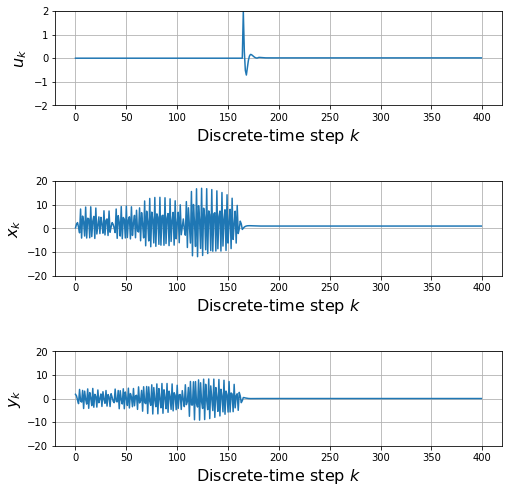

In [181]:
fig,axes = plt.subplots(nrows=3,ncols=1,figsize=(8,8))
sum_of_rewards = 0.0
        
func_key = 0
        
reset_test_x = 0.2
reset_test_y = 1.8
        
x_state_list = []
y_state_list = []
u_list = []
time_list = []
    
test_x = np.array([[reset_test_x, reset_test_y]])
        
Agent_step = 0
        
finish_flag = False
        
for test_step in range(400):
    
    x_state_list.append(test_x[0,0])
    y_state_list.append(test_x[0,1])
    time_list.append(test_step)
            
    if ((test_x[0,0]>X_min)and(test_x[0,0]<X_max))and((test_x[0,1]>Y_min)and(test_x[0,1]<Y_max)):
        func_key = 1
        # transforming the state ==============================
        input_state = torch.zeros(1,2)
        input_state[0,0] = (test_x[0,0]-0.994) # x - x_f
        input_state[0,1] = (test_x[0,1]-0.001) # y - y_f
        u, _, _, _ = NAF_DNN(input_state, None) 
        u = u.detach().numpy()[0] # numpy(1,)
        Agent_step += 1
                
    else:
        u = np.zeros(1)
    
    u_list.append(u[0])
    next_test_x = mira(test_x[0,0],test_x[0,1],u) # next_state
            
    if func_key==1:
        # Computing Reward
        reward = reward_function(next_test_x, test_x, u)
        if ((next_test_x[0,0]<=X_min)or(next_test_x[0,0]>=X_max))or((next_test_x[0,1]<=Y_min)or(next_test_x[0,1]>=Y_max)): # Out of Region
            reward = reward - 20.0
            finish_flag = True
        sum_of_rewards += reward
            
    if finish_flag:
        break
    test_x = next_test_x
        
mean_of_reward = sum_of_rewards/Agent_step
        #print(str(test_learning_step)+' learning: '+str(mean_of_reward))  
fig.subplots_adjust(wspace=0.3, hspace=0.8)
axes[0].plot(time_list,u_list)
axes[0].set_ylim(-2.0,2.0)
axes[0].set_xlabel('Discrete-time step $k$',fontsize=16)
axes[0].set_ylabel('$u_k$',fontsize=16)
axes[0].grid(True)
axes[1].plot(time_list,x_state_list)
axes[1].set_ylim(-20.0,20.0)
axes[1].set_xlabel('Discrete-time step $k$',fontsize=16)
axes[1].set_ylabel('$x_k$',fontsize=16)
axes[1].grid(True)
axes[2].plot(time_list,y_state_list)
axes[2].set_ylim(-20.0,20.0)
axes[2].set_xlabel('Discrete-time step $k$',fontsize=16)
axes[2].set_ylabel('$y_k$',fontsize=16)
axes[2].grid(True)

In [184]:
# main
seed = 0  
num = 10

np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

for iteration_learn in range(num):
    Mira_env = Environment(iteration_learn)
    Mira_env.run()

Net(
  (fc1): Linear(in_features=2, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=32, bias=True)
  (fc4_v): Linear(in_features=32, out_features=1, bias=True)
  (fc4_mu): Linear(in_features=32, out_features=1, bias=True)
  (fc4_L): Linear(in_features=32, out_features=1, bias=True)
)
10 Trajectory Finished
20 Trajectory Finished
30 Trajectory Finished
40 Trajectory Finished
50 Trajectory Finished


C:\Users\Junya\anaconda3\envs\chaos_env\lib\site-packages\ipykernel_launcher.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


100 Learning: [-4.31203588]
60 Trajectory Finished
200 Learning: [-4.39355586]
300 Learning: [-4.39101478]
400 Learning: [-5.39703643]
500 Learning: [-6.97490927]
600 Learning: [-6.96179272]
700 Learning: [-7.03570339]
800 Learning: [-7.14139345]
900 Learning: [-7.1319244]
1000 Learning: [-7.15970399]
1100 Learning: [-7.2037881]
1200 Learning: [-7.19724935]
1300 Learning: [-7.22281188]
1400 Learning: [-7.23753947]
1500 Learning: [-7.18199638]
1600 Learning: [-7.13232789]
1700 Learning: [-7.04531425]
1800 Learning: [-3.84039753]
1900 Learning: [-0.0031948]
2000 Learning: [-0.02459124]
2100 Learning: [-0.03128186]
2200 Learning: [-0.02773326]
2300 Learning: [-0.06302685]
2400 Learning: [-0.06839034]
2500 Learning: [-0.0697013]
2600 Learning: [-0.15531349]
2700 Learning: [-0.16488898]
2800 Learning: [-0.05783866]
70 Trajectory Finished
2900 Learning: [-0.12083426]
3000 Learning: [-0.12940825]
3100 Learning: [-0.10194945]
3200 Learning: [-0.08489425]
3300 Learning: [-0.08283986]
3400 Learn

1400 Learning: [-7.29927506]
1500 Learning: [-7.35295872]
1600 Learning: [-7.30453323]
1700 Learning: [-7.31031736]
1800 Learning: [-7.30742329]
1900 Learning: [-7.28766361]
2000 Learning: [-7.2441876]
2100 Learning: [-5.56523437]
2200 Learning: [-5.55446821]
2300 Learning: [-3.94270312]
2400 Learning: [-0.04496355]
2500 Learning: [-0.10538087]
2600 Learning: [-0.11838867]
2700 Learning: [-0.12425401]
2800 Learning: [-0.04250724]
2900 Learning: [-0.07577725]
3000 Learning: [-0.02536039]
3100 Learning: [-0.02887554]
70 Trajectory Finished
3200 Learning: [-0.04741005]
3300 Learning: [-0.03679751]
3400 Learning: [-0.06965462]
3500 Learning: [-0.06568414]
3600 Learning: [-0.07789489]
3700 Learning: [-0.06795068]
3800 Learning: [-0.12012353]
3900 Learning: [-0.11974315]
4000 Learning: [-0.10005473]
4100 Learning: [-0.04678535]
4200 Learning: [-0.1680758]
4300 Learning: [-0.08369535]
4400 Learning: [-0.0458453]
4500 Learning: [-0.04751216]
4600 Learning: [-0.07216943]
4700 Learning: [-0.0309

3400 Learning: [-0.00563559]
70 Trajectory Finished
3500 Learning: [-0.00824458]
3600 Learning: [-0.03153295]
3700 Learning: [-0.01872546]
3800 Learning: [-0.04042773]
3900 Learning: [-0.03643567]
4000 Learning: [-0.06302443]
4100 Learning: [-0.04193751]
4200 Learning: [-0.0364894]
4300 Learning: [-0.04038838]
4400 Learning: [-0.03978506]
4500 Learning: [-0.07292745]
4600 Learning: [-0.03195353]
4700 Learning: [-0.06730047]
4800 Learning: [-0.04323201]
4900 Learning: [-0.07743125]
5000 Learning: [-0.04602481]
5100 Learning: [-0.08163104]
5200 Learning: [-0.08294768]
5300 Learning: [-0.05170324]
5400 Learning: [-0.13327938]
5500 Learning: [-0.17719947]
5600 Learning: [-0.05679923]
5700 Learning: [-0.09676414]
5800 Learning: [-0.08384475]
5900 Learning: [-0.09250143]
6000 Learning: [-0.07415214]
6100 Learning: [-0.11533893]
80 Trajectory Finished
6200 Learning: [-0.082716]
6300 Learning: [-0.09626662]
6400 Learning: [-0.09435483]
6500 Learning: [-0.04430858]
6600 Learning: [-0.04736159]


4200 Learning: [-0.0998814]
4300 Learning: [-0.09442568]
4400 Learning: [-0.07381876]
4500 Learning: [-0.1705644]
4600 Learning: [-0.16427807]
4700 Learning: [-0.08882756]
4800 Learning: [-0.10491787]
4900 Learning: [-0.0746247]
5000 Learning: [-0.1365364]
5100 Learning: [-0.1721058]
5200 Learning: [-0.11420804]
5300 Learning: [-0.11183466]
5400 Learning: [-0.08190656]
5500 Learning: [-0.0737483]
5600 Learning: [-0.13259]
5700 Learning: [-0.06220364]
5800 Learning: [-0.10719756]
5900 Learning: [-0.09243061]
6000 Learning: [-0.03153841]
6100 Learning: [-0.03831423]
6200 Learning: [-0.0732398]
6300 Learning: [-0.07335883]
6400 Learning: [-0.0799902]
6500 Learning: [-0.00945906]
80 Trajectory Finished
6600 Learning: [-0.15373259]
6700 Learning: [-0.06503075]
6800 Learning: [-0.01183102]
6900 Learning: [-0.0206421]
7000 Learning: [-0.00938267]
7100 Learning: [-0.0581184]
7200 Learning: [-0.01742242]
7300 Learning: [-0.11723541]
7400 Learning: [-0.09358106]
7500 Learning: [-0.00383412]
7600

6000 Learning: [-0.06053227]
6100 Learning: [-0.11207559]
6200 Learning: [-0.04493302]
6300 Learning: [-0.09389911]
6400 Learning: [-0.1474406]
6500 Learning: [-0.09517929]
6600 Learning: [-0.05358467]
6700 Learning: [-0.06378331]
6800 Learning: [-0.01028445]
6900 Learning: [-0.05752635]
7000 Learning: [-0.0510632]
7100 Learning: [-0.02555755]
7200 Learning: [-0.02326431]
7300 Learning: [-0.08604296]
7400 Learning: [-0.06307376]
7500 Learning: [-0.06806816]
7600 Learning: [-0.00213086]
7700 Learning: [-0.02718002]
7800 Learning: [-0.07318939]
7900 Learning: [-0.07535046]
8000 Learning: [-0.0395044]
8100 Learning: [-0.03022663]
8200 Learning: [-0.04906236]
8300 Learning: [-0.0302773]
8400 Learning: [-0.02976192]
8500 Learning: [-0.08695251]
8600 Learning: [-0.06802434]
90 Trajectory Finished
8700 Learning: [-0.05430519]
8800 Learning: [-0.00318228]
8900 Learning: [-0.09710772]
9000 Learning: [-0.00773108]
9100 Learning: [-0.02180454]
9200 Learning: [-0.01633231]
9300 Learning: [-0.01240

## Learning Curves

In [186]:
test_data_set = []
num = 10
for i in range(num):

    test_data = open("return_list_"+str(i)+".txt", "r")

    lines = test_data.readlines()

    plot1 = []
    x = []

    for line in range(len(lines)):
        plot1.append(float(lines[line]))
        #print(lines[line])
        x.append(line)
    test_data_set.append(plot1)

    test_data.close()


In [194]:
length = len(test_data_set[0])
print(length)

109


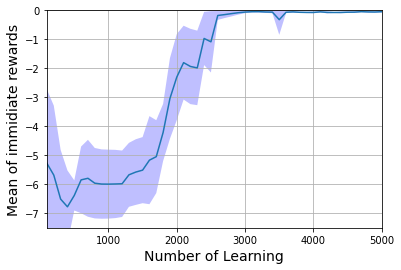

In [209]:
plot1 = []
plot2 = []
plot3 = []
xplot = []
maxplot = []
minplot = []

for i in range(length-50):
    temp = 0

    for j in range(num):
        temp = temp + test_data_set[j][i]
    temp = temp / (num)
    temp2 = 0
    for k in range(num):
        temp2 = temp2 + (test_data_set[k][i]-temp)**(2)
    temp2 = temp2/(num-1)
    plot1.append(temp)
    plot2.append(1.96*np.sqrt(temp2/num)+temp)
    plot3.append(-1.96*np.sqrt(temp2/num)+temp)
    xplot.append((i+1)*100)
    
plt.xlim(100, 5000)
plt.ylim(-7.5, 0.0)
plt.xlabel("Number of Learning",fontsize=14)
plt.ylabel("Mean of immidiate rewards",fontsize=14)
plt.plot(xplot, plot1)
plt.grid(True)
plt.fill_between(xplot, plot2, plot3, facecolor='b',alpha=0.25)